# The Hunt for Ramsey Lower Bounds

In this notebook, we'll implement various constructions and start experimenting with them. 

In [18]:
# imports
from random import choice, choices, sample
import collections 
import itertools

In [19]:
def num_cliques(g, size):
    '''Faster way to count number of cliques than subgraph_search_count'''
    return len(list(g.all_cliques(size, size)))

## Implementation of the Exercise 5 Construction 

We created a file called `pseudorandom-constructions.sage` which you may access to create the Conlon-Ferber graph (and other graphs possibly in the future).

In [1]:
from constructions import conlon_ferber
cf8 = conlon_ferber(8)
print(cf8.order(), cf8.size(), cf8.complement().size())

255 16320 16065


In [23]:
print(num_cliques(cf8, 4), num_cliques(cf8.complement(), 4))

2741760 2329425


In [6]:
paley17=graphs.PaleyGraph(17)

In [8]:
subg = cf8.subgraph_search(paley17, induced=True)

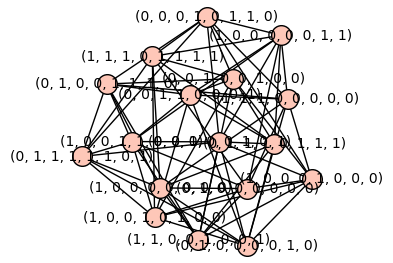

[(1, 0, 0, 0, 0, 0, 0, 0), (0, 1, 0, 0, 0, 0, 0, 0), (1, 1, 1, 0, 0, 0, 0, 0), (1, 0, 0, 0, 1, 0, 0, 0), (0, 0, 1, 0, 0, 1, 0, 0), (1, 0, 0, 1, 0, 1, 0, 0), (0, 1, 0, 0, 0, 0, 1, 0), (0, 0, 0, 1, 0, 1, 1, 0), (0, 1, 0, 0, 1, 1, 1, 0), (0, 0, 1, 1, 0, 0, 0, 1), (1, 1, 0, 0, 1, 0, 0, 1), (1, 0, 0, 1, 1, 0, 0, 1), (0, 0, 0, 0, 0, 1, 0, 1), (0, 1, 1, 1, 1, 1, 0, 1), (1, 0, 0, 0, 0, 0, 1, 1), (0, 1, 1, 1, 0, 1, 1, 1), (1, 1, 1, 0, 1, 1, 1, 1)]
3 3


In [10]:
subg.show()
print(subg.vertices())
print(subg.clique_number(), subg.complement().clique_number())

# Randomized Hill Climbing -- Two Approaches

1. Start with a random sub-graph on 17 vertices. 
2. Calculate an objective function. 
3. If a neighboring graph (swapping out one vertex, or maybe even two) has a better objective value, then move to that. 
4. Calculate the clique numbers and see if they're good. Repeat. 
5. But if not, go back to step 1. 

## Attempt 1

Some of these objectives look promising, but get stuck

In [24]:
# Objective function #1
# Compares number of edges to that of its complemnet. Inspired by the fact that many Ramsey lower bounds are isomorphic to their complement.
def objective_edges(R, G):
    subG = G.subgraph([G.vertices()[i] for i in R])
    return abs(len(subG.edges()) - len(subG.complement().edges()))

In [25]:
# Objective function #2
# Compares degree sequence to that of its complemnet. Inspired by the fact that many Ramsey lower bounds are isomorphic to their complement.
def objective_degree_counts(R, G):
    subG = G.subgraph([G.vertices()[i] for i in R])
    compG = subG.complement()
    
    sub_degrees = subG.degree()
    comp_degrees = compG.degree()
    
    sub_count = collections.Counter(sub_degrees)
    comp_count = collections.Counter(comp_degrees)
    
    tally = 0
    for key in set(sub_count.keys()).union(set(comp_count.keys())):
        tally += abs(sub_count[key] - comp_count[key])
    return tally

In [26]:
# Objective function #3
# Compares number of triangles to that of its complemnet. Inspired by the fact that many Ramsey lower bounds are isomorphic to their complement.
def objective_num_triangles(R, G): 
    subG = G.subgraph([G.vertices()[i] for i in R])
    compG = subG.complement()
    return abs(subG.triangles_count() - compG.triangles_count())

In [27]:
# Objective function #4: The most effective objective function.
# Reduces average of number of K_4s and number of independent sets. 
def objective_reduce_k4s(R, G):
    subG = G.subgraph([G.vertices()[i] for i in R])
    compG = subG.complement()
    val = 0.5 * num_cliques(subG, 4) + (1 - 0.5)*num_cliques(compG, 4)
    #val = max(subG.subgraph_search_count(graphs.CompleteGraph(4)), compG.subgraph_search_count(graphs.CompleteGraph(4)))
    return val

In [28]:
# Objective function #5
def objective_cliques_then_IS(R, G): 
    subG = G.subgraph([G.vertices()[i] for i in R])
    compG = subG.complement()
    if subG.clique_number() < 4: 
        return num_cliques(compG, 4)
    else: 
        return num_cliques(subG, 4) + num_cliques(compG, 4)

In [29]:
# Simply a helper method to find an arg min in a dictionary
def find_argmin(dictionary):
    
    min_keys = []
    min_val = float('inf')
    for key in dictionary:
        if dictionary[key] < min_val:
            min_val = dictionary[key]
    for key in dictionary:
        if dictionary[key] == min_val:
            min_keys.append(key)
    
    return min_keys, min_val

In [30]:
def local_search(G):
    # First, start at a random 17 vertices. We will keep track of our state of 17 vertices, as well as the complement
    # list to save time. 
    curr_list = sample(range(len(G.vertices())), 17) 
    complement = list(set(range(len(G.vertices()))) - set(curr_list))
    
    can_locally_move = True 
    iteration = 0
    
    while can_locally_move: 
        curr_graph = G.subgraph([G.vertices()[i] for i in curr_list])
        curr_clique_num = curr_graph.clique_number()
        curr_independence_num = curr_graph.complement().clique_number()
        current_objective_value = objective_reduce_k4s(curr_list, G) # !!Replace with desired objective function!!
        
        print("Current Graph's Clique and Independence Number: ", curr_clique_num, curr_independence_num)
        print("Current Objective Value: ", current_objective_value)
        
        if curr_clique_num < 4 and curr_independence_num < 4: 
            print("We found it!!")
            print(curr_list)
            break
        
        local_values = dict() # A dictionary of all nearby states and their corresponding values, to determine the next move.
        
        for (v_r, v_a) in itertools.product(curr_list, complement): # This is swapping out v_r and adding in v_a (a swap).
            potential = copy(curr_list)
            potential.remove(v_r)
            potential.append(v_a)
            local_values[(v_r, v_a)] = objective_reduce_k4s(potential, G) # !!Replace with desired objective function!!
        
        min_keys, min_val = find_argmin(local_values)
        
        if min_val <= current_objective_value:
            next_step = choice(min_keys) 
            print(f"Number of possible local moves: {len(min_keys)}")
            print(f"End of Iteration: {iteration}            Decreased by: {current_objective_value - min_val}")
            print()
            
            curr_list.remove(next_step[0]) # Keeping track of the state we are in.
            curr_list.append(next_step[1])
            complement.remove(next_step[1])
            complement.append(next_step[0])
            iteration += 1
        else:
            can_locally_move = False
            print("No Further Local Moves Found")
            return curr_list
            

In [31]:
end_list = local_search(cf8)

Current Graph's Clique and Independence Number:  5 5
Current Objective Value:  30.0000000000000
Number of possible local moves: 1
End of Iteration: 0            Decreased by: 10.0000000000000

Current Graph's Clique and Independence Number:  5 5
Current Objective Value:  20.0000000000000
Number of possible local moves: 1
End of Iteration: 1            Decreased by: 5.00000000000000

Current Graph's Clique and Independence Number:  5 4
Current Objective Value:  15.0000000000000
Number of possible local moves: 5
End of Iteration: 2            Decreased by: 3.00000000000000

Current Graph's Clique and Independence Number:  4 4
Current Objective Value:  12.0000000000000
Number of possible local moves: 1
End of Iteration: 3            Decreased by: 1.50000000000000

Current Graph's Clique and Independence Number:  4 4
Current Objective Value:  10.5000000000000
Number of possible local moves: 3
End of Iteration: 4            Decreased by: 0.500000000000000

Current Graph's Clique and Indepen

In [32]:
end_graph = cf8.subgraph([cf8.vertices()[i] for i in end_list])

## Attempt 2

This one finds the R(4, 4) lower bound!

Similar randomized local search idea with a slightly different local move:
1. Start with a random subgraph on 17 vertices
2. Repeat:
   - Find a maximum clique or IS (whichever is larger), pick a random vertex v from it.
   - Remove v from the subgraph.
   - Find a vertex u from cf8 to add which minimizes the objectives (in order of priority): 
      - Size of largest clique / IS created by adding u
      - Number of such cliques/ISs created by adding u
   - Among all such vertices, pick a random one to add to the subgraph

In [40]:
def find_better(g, g_comp, sub, to_remove):
    '''Find a vertex from g to replace to_remove in sub'''
    sub.delete_vertex(to_remove)
    sub_comp = sub.complement()

    # Iterate through the vertices of g, and score them based on the sizes / numbers of 
    # cliques and independent sets they create in sub
    best = (infinity, infinity)
    best_vs = None
    for v in g.vertices():
        if v not in sub and v != to_remove:
            
            # Compute a score for vertex v
            induced = sub.subgraph(g.neighbors(v))
            cliques = induced.cliques_maximum()

            comp_induced = sub_comp.subgraph(g_comp.neighbors(v))
            indeps = comp_induced.cliques_maximum()
            
            # Score = (size largest clique/IS, # of them)
            if len(cliques[0]) > len(indeps[0]):
                score = (len(cliques[0]), len(cliques))
            elif len(cliques[0]) < len(indeps[0]):
                score = (len(indeps[0]), len(indeps))
            else:
                score = (len(cliques[0]), len(cliques) + len(indeps))
            
            # Compare scores, and update best vertices found so far
            if score < best:
                best = score
                best_vs = [v]
            elif score == best:
                best_vs.append(v)
    
    return g.subgraph(sub.vertices() + [choice(best_vs)])


def elim_clique_or_indep(g, g_comp, sub):
    '''Eliminate and replace a vertex from a max clique or independent set (whichever is larger)'''
    a_clique = sub.clique_maximum()
    a_indep = sub.complement().clique_maximum()
    
    if len(a_clique) > len(a_indep):
        to_remove = choice(a_clique)
    elif len(a_clique) < len(a_indep):
        to_remove = choice(a_indep)
    else:
        to_remove = choice(a_clique + a_indep)

    return find_better(g, g_comp, sub, to_remove)

In [41]:
def local_search2(G, subg_size=17, k=4):
    '''Search graph G for a subgraph of size subg_size which provides a lower bound for R(k, k).
    That is, the subgraph should have no cliques or independent sets of size k.
    '''
    Gcomp = G.complement()
    
    subg = G.subgraph(sample(G.vertices(), subg_size))
    print(f'Starting subgraph has order: {subg.order()}')
    print(f'Clique and Independence number: {subg.clique_number(), subg.complement().clique_number()}')

    for i in range(10000):
        subg = elim_clique_or_indep(G, Gcomp, subg)
        
        cn = subg.clique_number()
        alpha = subg.complement().clique_number()
        print(f'Subg at iter {i} has CN and IN: {cn} {alpha}')
        if cn <= k-1 and alpha <= k-1:
            print(f'Found objective in iter {i}!')
            break
    
    return subg

In [42]:
subg = local_search2(cf8, subg_size=17, k=4)

Starting subgraph has order: 17
Clique and Independence number: (5, 5)
Subg at iter 0 has CN and IN: 4 5
Subg at iter 1 has CN and IN: 4 4
Subg at iter 2 has CN and IN: 4 4
Subg at iter 3 has CN and IN: 4 4
Subg at iter 4 has CN and IN: 4 4
Subg at iter 5 has CN and IN: 4 4
Subg at iter 6 has CN and IN: 4 4
Subg at iter 7 has CN and IN: 4 4
Subg at iter 8 has CN and IN: 4 4
Subg at iter 9 has CN and IN: 4 4
Subg at iter 10 has CN and IN: 4 4
Subg at iter 11 has CN and IN: 4 4
Subg at iter 12 has CN and IN: 4 4
Subg at iter 13 has CN and IN: 4 4
Subg at iter 14 has CN and IN: 4 4
Subg at iter 15 has CN and IN: 4 4
Subg at iter 16 has CN and IN: 4 4
Subg at iter 17 has CN and IN: 4 4
Subg at iter 18 has CN and IN: 4 4
Subg at iter 19 has CN and IN: 4 4
Subg at iter 20 has CN and IN: 4 4
Subg at iter 21 has CN and IN: 4 4
Subg at iter 22 has CN and IN: 4 4
Subg at iter 23 has CN and IN: 4 4
Subg at iter 24 has CN and IN: 4 4
Subg at iter 25 has CN and IN: 4 4
Subg at iter 26 has CN and IN

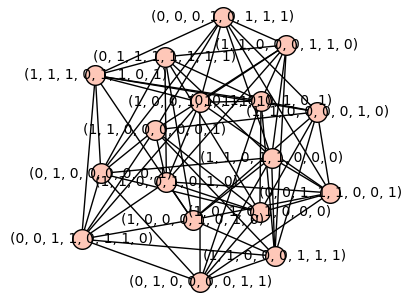

True
17 3 3


In [43]:
subg.show()
print(subg.is_isomorphic(paley17))
print(subg.order(), subg.clique_number(), subg.complement().clique_number())

Note, it appears that Attempt 1 converges quite quickly to a solution with clique number 3 and independence number 4 (or vice versa), while Attempt 2 may take longer to find such an example. It could be beneficial to try combining the approaches: using Attempt 1 as a warm start for Attempt 2.